# Cancer Diagnosis Prediction 

## Feature Selection

Approach I: 
1. Train base models - Random Forest, SVM and KNN - on all prepared features. 
2. Devide features by logical categories and apply Lasso Regression to select important features within these categories, as well as remove highly correlated between each other features. 
3. Use the models again on selected features. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
one_hot_train = pd.read_csv('one_hot_train.csv') 
one_hot_test = pd.read_csv('one_hot_test.csv') 

In [4]:
patient_id = one_hot_test['patient_id']

one_hot_train.drop(columns=['patient_id'], axis=1, inplace=True)
one_hot_test.drop(columns=['patient_id'], axis=1, inplace=True)

In [5]:
one_hot_train.isna().sum().sort_values(ascending=False)

patient_zip3                           0
breast_cancer_diagnosis_code_C5021     0
breast_cancer_diagnosis_code_C50212    0
breast_cancer_diagnosis_code_C50219    0
breast_cancer_diagnosis_code_C5031     0
                                      ..
patient_state_AK                       0
patient_state_AL                       0
patient_state_AR                       0
patient_state_AZ                       0
Division_West South Central            0
Length: 229, dtype: int64

In [6]:
target = one_hot_train['DiagPeriodL90D']
one_hot_train.drop(columns=target.name, axis=1, inplace=True) 


## Apply Lasso Regression for Feature Selection

In [7]:
# Define dictionary to group columns based on themes
column_groups = {
    'locations': ['patient_state', 'Region', 'Division'],
    'age': ['age'],
    'race': ['race'],
    'education': ['education'],
    'income': ['income'],
    'rent': ['rent'],
    'social_status': ['married', 'divorced', 'widowed'],
    'empl_status': ['labor', 'employ'],
    'home_status': ['home', 'housing'],
    'health_status': ['payer', 'veteran', 'disabled', 'insured'],
    'gender_status': ['male', 'gender'],
    'diagnosis_status': ['diagnosis'],
    'air_quality': ['Ozone', 'PM25', 'N02']
}

# Create dictionary to store sliced dataframes
sliced_dfs = {}

# Iterate over column_groups dictionary
for group, columns in column_groups.items():
    # Filter columns based on column name patterns
    relevant_columns = [column for column in one_hot_train.columns if any(col in column for col in columns)]
    # Slice dataframe based on relevant columns
    sliced_dfs[group] = one_hot_train[relevant_columns]

# Access sliced dataframes using keys from column_groups dictionary
locations = sliced_dfs['locations']
age = sliced_dfs['age']
race = sliced_dfs['race']
education = sliced_dfs['education']
income = sliced_dfs['income']
rent = sliced_dfs['rent']
social_status = sliced_dfs['social_status']
empl_status = sliced_dfs['empl_status']
home_status = sliced_dfs['home_status']
health_status = sliced_dfs['health_status']
diagnosis_status = sliced_dfs['diagnosis_status']
air_quality = sliced_dfs['air_quality']



In [8]:
from lasso import apply_lasso

In [9]:
important_ages= apply_lasso(age, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23436320180043563
Important Features: Index(['patient_age', 'age_30s'], dtype='object')


In [10]:
important_locs= apply_lasso(locations, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.2340346520550925
Important Features: Index(['patient_state_CA', 'patient_state_CO', 'patient_state_IL',
       'patient_state_KY', 'patient_state_NY', 'patient_state_VA',
       'Division_Pacific', 'Division_West North Central'],
      dtype='object')


In [11]:
important_race_info = apply_lasso(race, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.2344623606899113
Important Features: Index(['patient_race_Unknown', 'patient_race_White'], dtype='object')


In [12]:
important_education_info = apply_lasso(education, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23472063705491003
Important Features: Index(['education_less_highschool', 'education_bachelors'], dtype='object')


In [13]:
important_income_info = apply_lasso(income, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.2348618173059057
Important Features: Index(['income_household_25_to_35', 'income_household_75_to_100',
       'income_individual_median'],
      dtype='object')


In [14]:
important_social_info = apply_lasso(social_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23488479137924861
Important Features: Index(['widowed'], dtype='object')


In [15]:
important_empl_info = apply_lasso(empl_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.2348721455511149
Important Features: Index(['labor_force_participation'], dtype='object')


In [16]:
important_home_info = apply_lasso(home_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23494151110930983
Important Features: Index(['home_value'], dtype='object')


In [17]:
important_health_info = apply_lasso(health_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23388649164479847
Important Features: Index(['disabled', 'health_uninsured', 'payer_type_COMMERCIAL',
       'payer_type_MEDICARE ADVANTAGE', 'payer_type_Unknown'],
      dtype='object')


In [18]:
important_rent_info = apply_lasso(rent, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23495126730865898
Important Features: Index(['rent_median'], dtype='object')


In [19]:
important_diagnosis_info = apply_lasso(diagnosis_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.15005255046742388
Important Features: Index(['breast_cancer_diagnosis_code_1741',
       'breast_cancer_diagnosis_code_1742',
       'breast_cancer_diagnosis_code_1743',
       'breast_cancer_diagnosis_code_1744',
       'breast_cancer_diagnosis_code_1745',
       'breast_cancer_diagnosis_code_1746',
       'breast_cancer_diagnosis_code_1748',
       'breast_cancer_diagnosis_code_1749',
       'breast_cancer_diagnosis_code_19881',
       'metastatic_cancer_diagnosis_code_C7981'],
      dtype='object')


In [20]:
important_air_info = apply_lasso(air_quality, target)

Best Parameters for LASSO: {'lasso__alpha': 0.1}
Best MSE for LASSO: 0.23498375813624522
Important Features: Index([], dtype='object')


Let's create a list of features that didn't have a group. 

In [21]:
miscellaneous  = ['patient_zip3', 'population', 'density', 'poverty', 'commute_time', 'family_size', 'limited_english', 'farmer']

Now we can crate a df with features that were selected by the Lasso model, didn't have the groups or weren't specified by Lasso as important. To these features we are going to apply another selection method.

In [22]:
important_feats_train = one_hot_train[
    important_health_info + 
    important_home_info + 
    important_social_info + 
    important_income_info + 
    important_education_info + 
    important_race_info + 
    important_locs + 
    important_ages + 
    important_rent_info + 
    important_diagnosis_info +
    miscellaneous + 
    list(empl_status.columns) +
    list(air_quality.columns)
    ]
important_feats_train

,disabled,health_uninsured,payer_type_COMMERCIAL,payer_type_MEDICARE ADVANTAGE,payer_type_Unknown,home_value,widowed,income_household_25_to_35,income_household_75_to_100,income_individual_median,education_less_highschool,education_bachelors,patient_race_Unknown,patient_race_White,patient_state_CA,patient_state_CO,patient_state_IL,patient_state_KY,patient_state_NY,patient_state_VA,Division_Pacific,Division_West North Central,patient_age,age_30s,rent_median,breast_cancer_diagnosis_code_1741,breast_cancer_diagnosis_code_1742,breast_cancer_diagnosis_code_1743,breast_cancer_diagnosis_code_1744,breast_cancer_diagnosis_code_1745,breast_cancer_diagnosis_code_1746,breast_cancer_diagnosis_code_1748,breast_cancer_diagnosis_code_1749,breast_cancer_diagnosis_code_19881,metastatic_cancer_diagnosis_code_C7981,patient_zip3,population,density,poverty,commute_time,family_size,limited_english,farmer,labor_force_participation,unemployment_rate,self_employed,Ozone,PM25,N02
0,12.871429,11.200000,0.0,0.0,0.0,2.646343e+05,4.442857,10.142857,12.742857,24563.57143,33.257143,8.357143,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,84,14.014286,1165.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,924,31437.75000,1189.562500,22.542857,27.814286,3.928571,10.100000,0.000000,61.528571,8.471429,13.428571,52.237210,8.650555,18.606528
1,8.957576,7.018182,1.0,0.0,0.0,6.776885e+05,4.651515,5.163636,12.469697,41287.27273,14.230303,23.739394,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,62,13.418182,2003.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,928,39121.87879,2295.939394,10.109091,30.606061,3.622727,8.057576,0.027273,65.230303,5.103030,15.224242,42.301121,8.487175,20.113179
2,11.253333,15.066667,1.0,0.0,0.0,2.377131e+05,4.710000,6.763333,13.560000,40399.03333,10.811667,19.678333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43,13.545000,1235.907407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,760,21996.68333,626.236667,9.663333,31.394915,3.260667,3.356667,3.650847,66.428333,4.560000,13.722034,40.108207,7.642753,14.839351
3,8.845238,4.404762,1.0,0.0,0.0,1.012474e+06,4.623810,4.380952,10.721429,55336.28571,5.835714,33.285714,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,45,12.464286,2354.738095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,926,32795.32558,1896.220930,8.688095,27.561905,3.098095,5.280952,0.052381,64.430952,5.264286,18.502381,42.070075,7.229393,15.894123
4,15.276000,12.088000,1.0,0.0,0.0,2.498457e+05,5.406000,11.462000,12.480000,29073.18367,11.576000,13.978000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,10.364000,919.743590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,836,10886.26000,116.886000,11.224000,26.170213,3.352653,1.946000,6.890909,57.488000,4.258000,13.029545,41.356058,4.110749,11.722197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12897,17.400000,6.300000,0.0,0.0,1.0,1.005470e+05,5.705882,10.364706,11.047059,27888.52941,12.923529,14.400000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,12.705882,772.647059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,436,19413.05882,1196.805882,23.600000,19.841176,3.039412,0.864706,0.023529,61.429412,9.135294,9.105882,38.753055,8.068682,21.140731
12898,11.243210,3.845679,1.0,0.0,0.0,8.179491e+05,5.466667,5.148750,11.286250,52778.65000,8.916049,26.903704,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50,13.101235,2223.445946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,945,30153.87952,976.289157,7.837037,34.700000,3.271125,5.411250,0.416250,63.281481,5.332099,14.116250,36.469947,6.265266,10.728732
12899,8.845238,4.404762,1.0,0.0,0.0,1.012474e+06,4.623810,4.380952,10.721429,55336.28571,5.835714,33.285714,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,61,12.464286,2354.738095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,926,32795.32558,1896.220930,8.688095,27.561905,3.098095,5.280952,0.052381,64.430952,5.264286,18.502381,42.070075,7.229393,15.894123
12900,10.194737,6.392105,0.0,0.0,1.0,8.708732e+05,5.186842,7.589474,10.742105,3

In [23]:
important_feats_test = one_hot_test[
    important_health_info + 
    important_home_info + 
    important_social_info + 
    important_income_info + 
    important_education_info + 
    important_race_info + 
    important_locs + 
    important_ages + 
    important_rent_info + 
    important_diagnosis_info +
    miscellaneous + 
    list(empl_status.columns) + 
    list(air_quality.columns)
    ]

Let's check feature correlations and remove features with high correlations.

In [24]:
# Compute the correlation matrix
correlation_matrix = important_feats_train.corr()

# Set the threshold for high correlation
threshold = 0.7  # You can adjust this threshold as needed

# Find pairs of features with correlation above the threshold
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display pairs of features with high correlation
for pair in high_correlation_pairs:
    print(f"High correlation between {pair[0]} and {pair[1]}: {pair[2]}")

High correlation between disabled and income_household_25_to_35: 0.7231136467734144
High correlation between disabled and income_individual_median: -0.7168323413079525
High correlation between disabled and education_bachelors: -0.7473949509929
High correlation between disabled and labor_force_participation: -0.7871973905168711
High correlation between home_value and rent_median: 0.9034218318106001
High correlation between widowed and labor_force_participation: -0.7014492570225168
High correlation between income_household_25_to_35 and income_individual_median: -0.8124964068287303
High correlation between income_household_25_to_35 and education_bachelors: -0.7120724906899256
High correlation between income_household_25_to_35 and rent_median: -0.7327612295396232
High correlation between income_individual_median and education_bachelors: 0.8146836159218646
High correlation between income_individual_median and rent_median: 0.7411039816304006
High correlation between education_bachelors and r

In [25]:
lasso_cor_train = important_feats_train.drop([
    'disabled',
    'home_value', 
    'income_household_25_to_35', 
    'education_bachelors', 
    'Division_Pacific', 
    'population',
    'widowed',
    ], 
    axis=1
    )

lasso_cor_test = important_feats_test.drop([
    'disabled',
    'home_value', 
    'income_household_25_to_35', 
    'education_bachelors', 
    'Division_Pacific', 
    'population',
    'widowed', 
    ],  
    axis=1
    )


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Extract numerical columns for correlation analysis
numerical_columns = lasso_cor_train.select_dtypes(include='number')

# Calculate correlation matrix
correlation_matrix = numerical_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the threshold for significance
significant_corr_mask = np.abs(correlation_matrix) > 0.6

# Combine the upper triangle mask and the significance mask
final_mask = np.logical_and(mask, significant_corr_mask)

# Set values outside the final mask to NaN
correlation_matrix[~final_mask] = np.nan

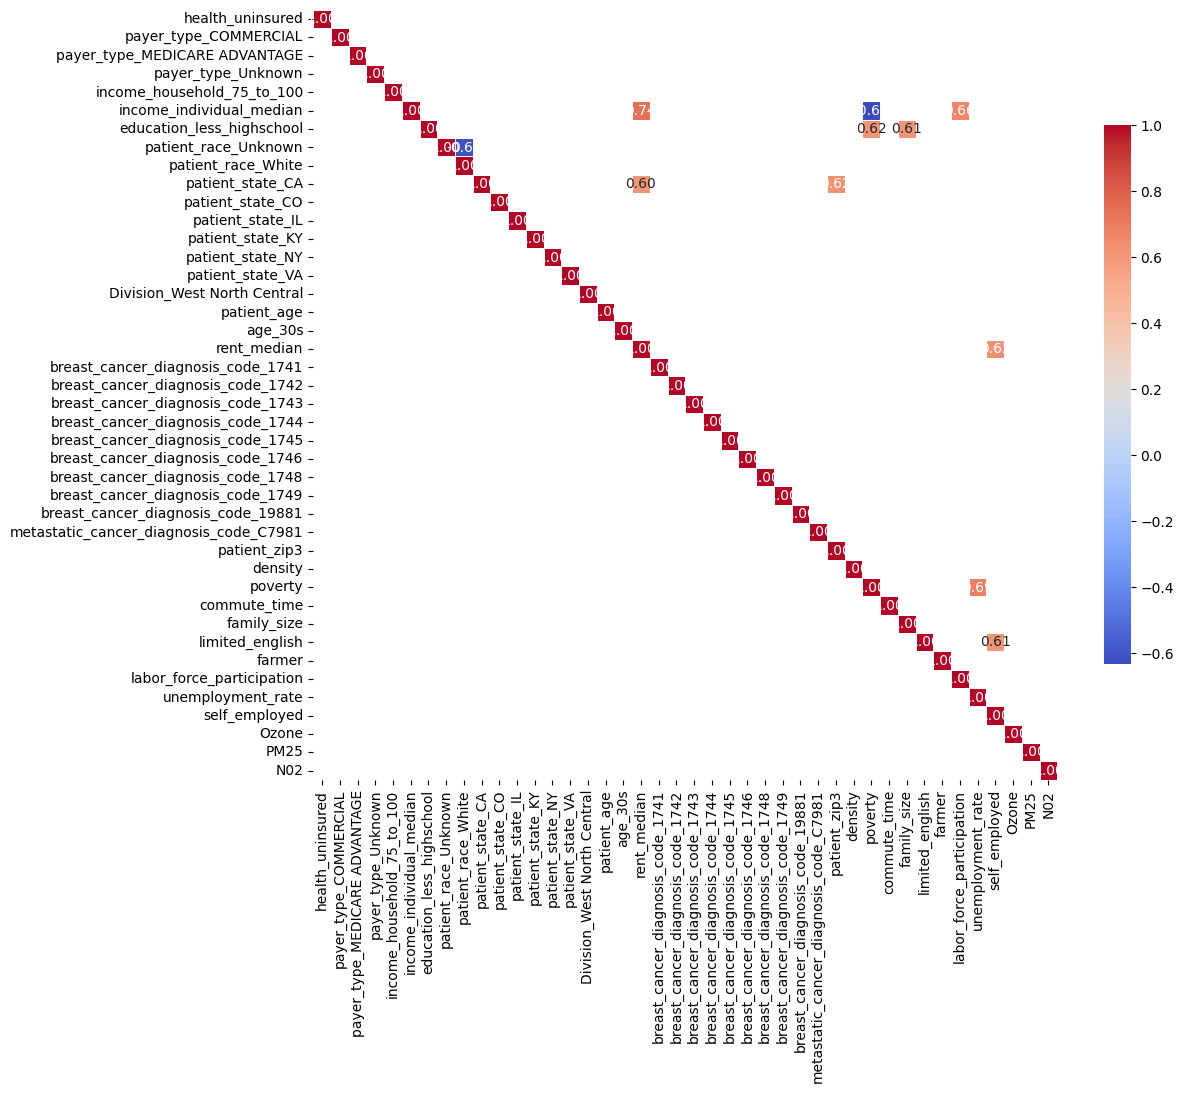

In [28]:
# Define the size of the figure
plt.figure(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={"shrink": 0.7})

# Show the plot

plt.show()

Let's split features on train and test to train the models for the baseline prediction. 

In [29]:
from train_test_simple_models import train_test_models

In [31]:
best_base_models, base_feature_importances, base_pipelines = train_test_models(one_hot_train, target)


Training RandomForest model with GridSearchCV...
Best Parameters for RandomForest: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best ROC for RandomForest: 0.7911373783758785

Best RandomForest Model Evaluation:
ROC AUC: 0.7796579513773156
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.52      0.66       948
           1       0.78      0.96      0.86      1633

    accuracy                           0.80      2581
   macro avg       0.84      0.74      0.76      2581
weighted avg       0.82      0.80      0.79      2581


Training SVM model with GridSearchCV...
Best Parameters for SVM: {'classifier__C': 1, 'classifier__gamma': 0.01}
Best ROC for SVM: 0.7896045439229106

Best SVM Model Evaluation:
ROC AUC: 0.7775899111417726
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.55      0.68       948
           1       0.79      0.96      0.87      1633

In [32]:
best_models, feature_importances, pipelines = train_test_models(lasso_cor_train, target)


Training RandomForest model with GridSearchCV...


Best Parameters for RandomForest: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best ROC for RandomForest: 0.7989457151224788

Best RandomForest Model Evaluation:
ROC AUC: 0.7797910190919872
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.54      0.67       948
           1       0.78      0.96      0.86      1633

    accuracy                           0.81      2581
   macro avg       0.83      0.75      0.77      2581
weighted avg       0.82      0.81      0.79      2581


Training SVM model with GridSearchCV...
Best Parameters for SVM: {'classifier__C': 0.1, 'classifier__gamma': 0.01}
Best ROC for SVM: 0.7879114654302398

Best SVM Model Evaluation:
ROC AUC: 0.7732723159725182
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.43      0.59       948
           1       0.75      0.97      0.85      1633

    accuracy                           0.77   

In [33]:
def feature_importance(feature_importances_dict):
    # Display feature importances
    for name, feature_importances in feature_importances_dict.items():
        print(f"\nFeature Importances for {name} model:")
        if feature_importances:
            for feature, importance in sorted(feature_importances.items(), key=lambda x: x[1], reverse=True):
                print(f"{feature}: {importance}")
        else:
            print(f"No feature importances available for {name} model.")


In [34]:
feature_importance(base_feature_importances)


Feature Importances for RandomForest model:
breast_cancer_diagnosis_code_1749: 0.31762260444435725
breast_cancer_diagnosis_code_1744: 0.0689488765813637
breast_cancer_diagnosis_code_1748: 0.052803982986035815
patient_age: 0.0401775901631281
breast_cancer_diagnosis_code_C50911: 0.028144663223853894
breast_cancer_diagnosis_code_C50919: 0.020621721817823714
breast_cancer_diagnosis_code_C50912: 0.018774380654162034
metastatic_cancer_diagnosis_code_C773: 0.017338646185375693
breast_cancer_diagnosis_code_C50412: 0.014756891653033564
breast_cancer_diagnosis_code_C50411: 0.013254638731371107
breast_cancer_diagnosis_code_1742: 0.010334636628125879
breast_cancer_diagnosis_code_1741: 0.010044520829288141
metastatic_cancer_diagnosis_code_C7981: 0.009883978706819323
breast_cancer_diagnosis_code_1745: 0.008983869857594848
breast_cancer_diagnosis_code_C50811: 0.0075799057016297895
widowed: 0.006613982216657557
commute_time: 0.006076726341568457
education_bachelors: 0.005489986955616122
patient_zip3:

In [35]:
feature_importance(feature_importances)


Feature Importances for RandomForest model:
breast_cancer_diagnosis_code_1749: 0.5048191960415883
breast_cancer_diagnosis_code_1744: 0.10682888381709353
breast_cancer_diagnosis_code_1748: 0.07324593688736487
patient_age: 0.04777779447802679
breast_cancer_diagnosis_code_1742: 0.02344961303659822
breast_cancer_diagnosis_code_1741: 0.020215280135270283
breast_cancer_diagnosis_code_1745: 0.018638071681568735
metastatic_cancer_diagnosis_code_C7981: 0.014836872983061668
commute_time: 0.010457011912424676
labor_force_participation: 0.00940103763260759
patient_zip3: 0.00901708990634864
rent_median: 0.009013479414106072
Ozone: 0.008953501824671825
self_employed: 0.008849698163166718
health_uninsured: 0.008656531387795706
income_individual_median: 0.008522737537778219
unemployment_rate: 0.008445537192460204
education_less_highschool: 0.008147799177417063
age_30s: 0.008133889658728815
income_household_75_to_100: 0.008121311657183066
poverty: 0.00796690935066607
family_size: 0.007634412881683084


In [36]:
def predict_test_set(pipelines, best_models, test, patient_id):
    """
    Predict the target variable using the provided models on the test set.
    
    Parameters:
        pipelines (dict): Dictionary containing the pipelines for each model.
        best_models (dict): Dictionary containing the best models for each classifier.
        test (pd.DataFrame): Test dataset.
        patient_id (pd.Series): Series containing patient IDs.
        
    Returns:
        predictions (dict): Dictionary containing the predicted values for each model.
    """
    predictions = {}
    for name, model in best_models.items():
        y_pred = model.predict(test)
        predictions[name] = y_pred

    # Insert patient_id to RandomForest predictions
    predictions['RandomForest'] = pd.DataFrame(predictions['RandomForest'], columns=['DiagPeriodL90D'])
    predictions['RandomForest'].insert(0, 'patient_id', patient_id)

    predictions['SVM'] = pd.DataFrame(predictions['SVM'], columns=['DiagPeriodL90D'])
    predictions['SVM'].insert(0, 'patient_id', patient_id)

    predictions['KNN'] = pd.DataFrame(predictions['SVM'], columns=['DiagPeriodL90D'])
    predictions['KNN'].insert(0, 'patient_id', patient_id)

    return predictions['RandomForest'], predictions['SVM'], predictions['KNN']

RandomForest_result, SVM_result, KNN_result = predict_test_set(pipelines, best_models, lasso_cor_test, patient_id)


In [47]:
len(feature_importances['RandomForest'].keys())

42

In [58]:
forest_imp_feats = pd.DataFrame(feature_importances['RandomForest'].keys(), columns=['imp_features'])
forest_imp_feats.to_csv('forest_imp_feats.csv', index=False)

In [37]:
RandomForest_result.to_csv('forest_result.csv', index=False)
SVM_result.to_csv('svm_result.csv', index=False)
KNN_result.to_csv('knn_result.csv', index=False)